## Content-based Image Retrieval

This notebook is prepared with the help of https://pyimagesearch.com/2020/03/30/autoencoders-for-content-based-image-retrieval-with-keras-and-tensorflow/  . Thanks to Adrian for these clear explanations.



I will use convolutional autoencoders to create a Content-based Image Retrieval system(CBIR) (i.e., image search engine).

To build an image retrieval system with an autoencoder, what we really care about is that latent-space representation vector.

Once an autoencoder has been trained to encode images, we can:

    Use the encoder portion of the network to compute the latent-space representation of each image in our dataset — this representation serves as our feature vector that quantifies the contents of an image
    Compare the feature vector from our query image to all feature vectors in our dataset (typically you would use either the Euclidean or cosine distance)
    
Feature vectors that have a smaller distance will be considered more similar, while images with a larger distance will be deemed less similar.

We can then sort our results based on the distance (from smallest to largest) and finally display the image retrieval results to the end user.




   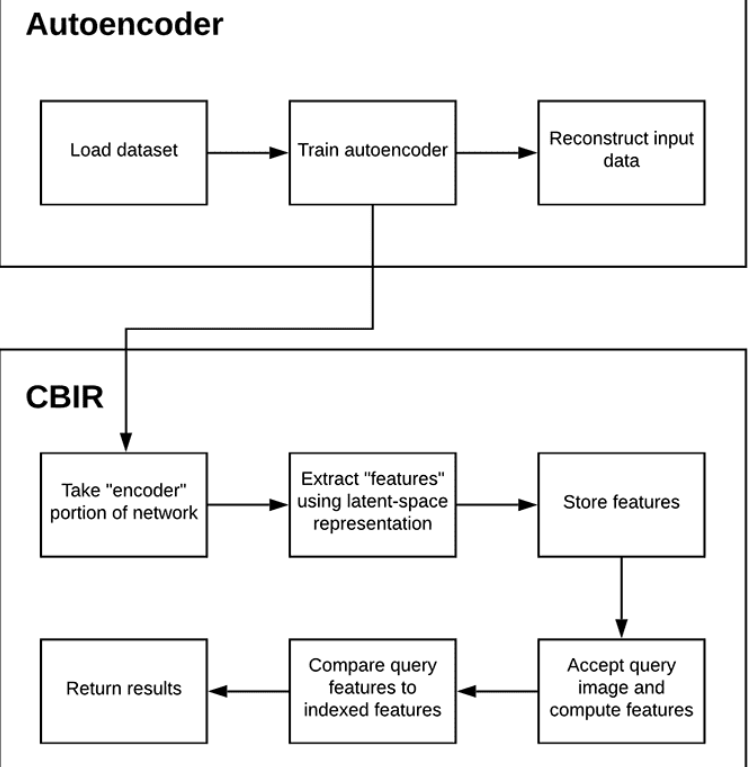

Again we build our autoencoder, but this time we will give a name to the Latent representation layer to use it while extracting features from dataset... this is the critical part for this code block

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

In [2]:
# our model will train on mnist dataset. because of that dimensions of input 
inputShape = (28, 28, 1)

#channel is at the end
chanDim = -1

#our latent representation will be 16 dims
latentDim=16
inputs = Input(shape=inputShape)
x = inputs
#first Conv layer 32 filters
x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)
#second Conv layer 64 filters
x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

# flatten the network and then construct our latent vector
volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latentDim, name="encoded")(x)

#output of encoder will be our input for decoder
x = Dense(np.prod(volumeSize[1:]))(latent)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

#transpose conv for reverse 
x = Conv2DTranspose(64, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)
x = Conv2DTranspose(32, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)
#apply a single CONV_TRANSPOSE layer used to recover the original shape
x = Conv2DTranspose(1, (3, 3), padding="same")(x)
outputs = Activation("sigmoid", name="decoded")(x)

# build the autoencoder model
autoencoder = Model(inputs, outputs, name="autoencoder")

In [3]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                       

We build our autoencoder, now we should train it with a proper dataset

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [5]:
def visualize_predictions(decoded, gt, samples=10):
    # initialize our list of output images
    outputs = None

    # loop over our number of output samples
    for i in range(0, samples):
        # grab the original image and reconstructed image
        original = (gt[i] * 255).astype("uint8")
        recon = (decoded[i] * 255).astype("uint8")

        # stack the original and reconstructed image side-by-side
        output = np.hstack([original, recon])

        # if the outputs array is empty, initialize it as the current
        # side-by-side image display
        if outputs is None:
            outputs = output

        # otherwise, vertically stack the outputs
        else:
            outputs = np.vstack([outputs, output])

    # return the output images
    return outputs

In [6]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

In [7]:
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...


In [8]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

In [9]:
# train the convolutional autoencoder
H = autoencoder.fit(trainX, trainX,validation_data=(testX, testX),epochs=EPOCHS,batch_size=BS)

Epoch 1/20
1875/1875 [==============================] - 19s 8ms/step - loss: 0.0184 - val_loss: 0.0121
Epoch 2/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0103 - val_loss: 0.0093
Epoch 3/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 4/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 5/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0082 - val_loss: 0.0090
Epoch 6/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 7/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 8/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 9/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 10/20
1875/1875 [==============================] - 16s 8ms/step - l

In [10]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite('recon_autoencoder.png', vis)

[INFO] making predictions...


True

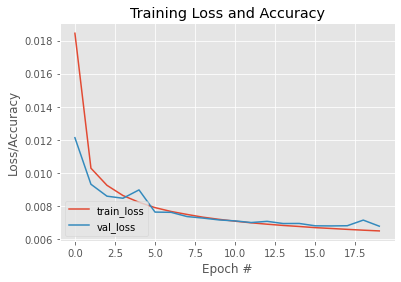

In [11]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('loss_plot_autoencoder.png')

In [13]:
# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save('autoencoder_cbir.h5', save_format="h5")

[INFO] saving autoencoder...


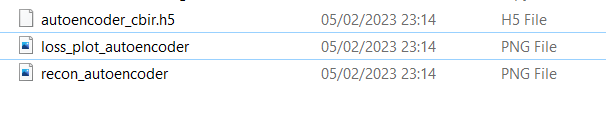

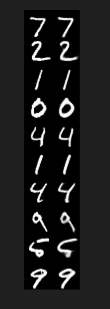

After we prepared our model, we need to encode all images and give them indexes. After collecting all indexes and features, we can make image search in these collections

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [16]:
# load the MNIST dataset
print("[INFO] loading MNIST training split...")
((trainX, _), (testX, _)) = mnist.load_data()

#add dimension for channel and normalize
trainX = np.expand_dims(trainX, axis=-1)
trainX = trainX.astype("float32") / 255.0

# load our autoencoder from disk
print("[INFO] loading autoencoder model...")
autoencoder = load_model('autoencoder_cbir.h5')

[INFO] loading MNIST training split...
[INFO] loading autoencoder model...


In [17]:
# create the encoder model which consists of *just* the encoder
# portion of the autoencoder
encoder = Model(inputs=autoencoder.input,outputs=autoencoder.get_layer("encoded").output)

In [18]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                             

In [19]:
# quantify the contents of our input images using the encoder
print("[INFO] encoding images...")
features = encoder.predict(trainX)

[INFO] encoding images...


In [21]:
features.shape

(60000, 16)

We encoded every image in Xtrain dataset and save them in 'features'. Now we will give them index numbers and save in a file to use for image search

In [22]:
indexes = list(range(0, trainX.shape[0]))
data = {"indexes": indexes, "features": features}

In [23]:
data

{'indexes': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,


In [28]:
import pickle

In [29]:
print("[INFO] saving index...")
f = open('features.pickle', "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] saving index...


We collected all images' features with 16dim in our features.pickle file... Now we can make a search in this file with our test set

In [30]:
# we will use euclidean for search parameter
def euclidean(a, b):
# compute and return the euclidean distance between two vectors
    return np.linalg.norm(a - b)

In [31]:
# we will take an image's features and compare them our with our
# dataset which we saved in 'features.pickle'
# according to the eucledian distance , we will take the smallest 64 results

def perform_search(queryFeatures, index, maxResults=64):
    # initialize our list of results
    results = []

    # loop over our index
    for i in range(0, len(index["features"])):
        # compute the euclidean distance between our query features
        # and the features for the current image in our index, then
        # update our results list with a 2-tuple consisting of the
        # computed distance and the index of the image
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))

    # sort the results and grab the top ones
    results = sorted(results)[:maxResults]

    # return the list of results
    return results

In [32]:
# load the autoencoder model and index from disk 
print("[INFO] loading autoencoder and index...")
autoencoder = load_model('autoencoder_cbir.h5')
index = pickle.loads(open('features.pickle', "rb").read())

[INFO] loading autoencoder and index...


In [33]:
testX = np.expand_dims(testX, axis=-1)
testX = testX.astype("float32") / 255.0

In [34]:
encoder = Model(inputs=autoencoder.input,outputs=autoencoder.get_layer("encoded").output)

In [35]:
print("[INFO] encoding testing images...")
features = encoder.predict(testX)

[INFO] encoding testing images...


In [36]:
features.shape

(10000, 16)

In [37]:
# randomly sample a set of testing query image indexes
queryIdxs = list(range(0, testX.shape[0]))
queryIdxs = np.random.choice(queryIdxs, size=10,replace=False)

In [38]:
queryIdxs

array([3377, 9237,  576,  121, 8588, 2063, 2343, 8616, 9724,  905])

We will make image search for these indexes' features in saved pickle file

In [40]:
from imutils import build_montages
#good method to show results

In [41]:
# loop over the testing indexes
for i in queryIdxs:
    # take the features for the current image, find all similar
    # images in our dataset, and then initialize our list of result
    # images
    queryFeatures = features[i]
    results = perform_search(queryFeatures, index, maxResults=225)
    images = []

    # loop over the results
    for (d, j) in results:
        # grab the result image, convert it back to the range
        # [0, 255], and then update the images list
        image = (trainX[j] * 255).astype("uint8")
        image = np.dstack([image] * 3)
        images.append(image)

    # display the query image
    query = (testX[i] * 255).astype("uint8")
    cv2.imshow("Query", query)

    # build a montage from the results and display it
    montage = build_montages(images, (28, 28), (15, 15))[0]
    cv2.imshow("Results", montage)
    cv2.waitKey(0)

You can see some of our results, Not perfect but enough to capture the main idea of this notebook

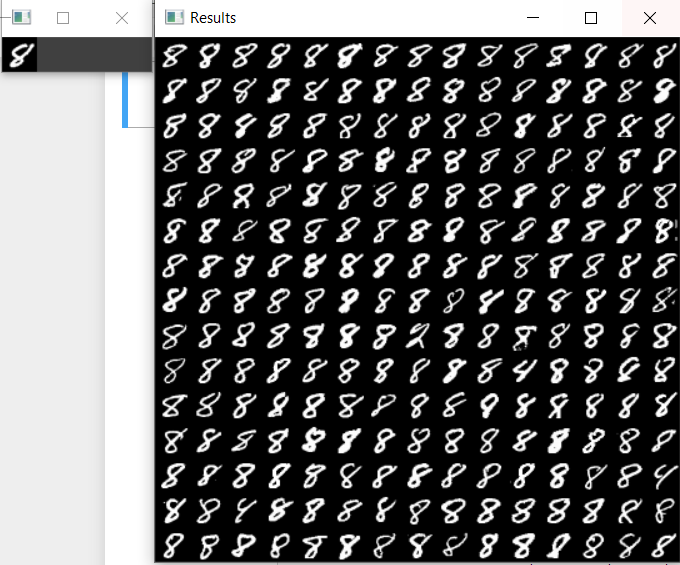

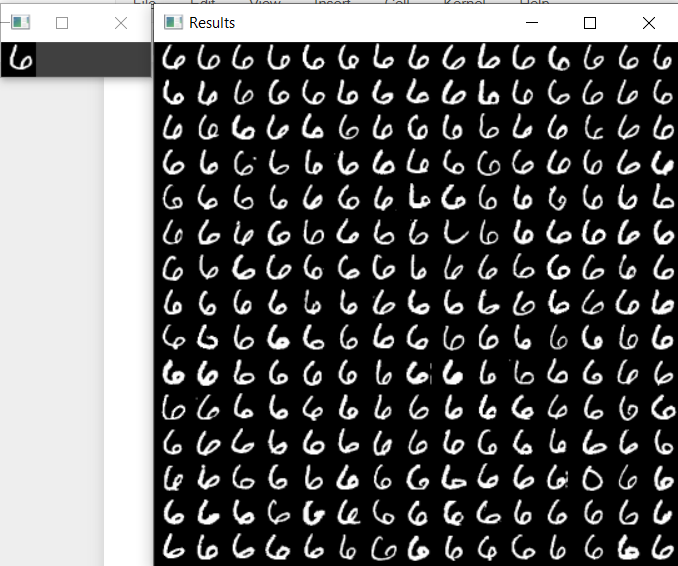

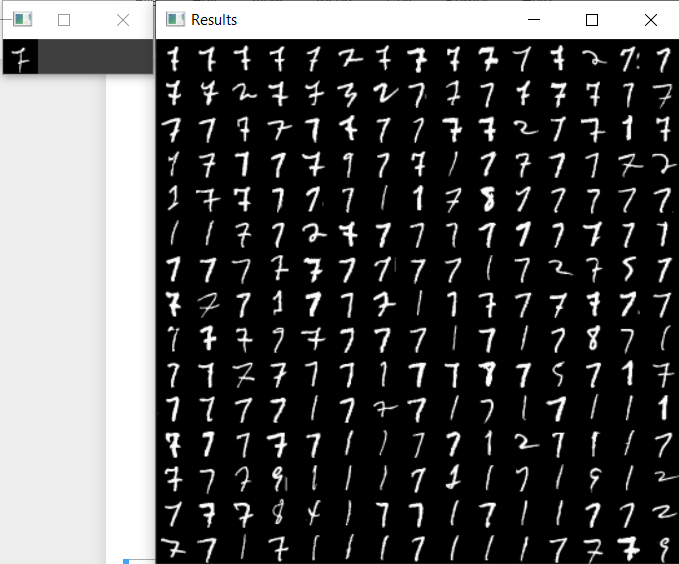

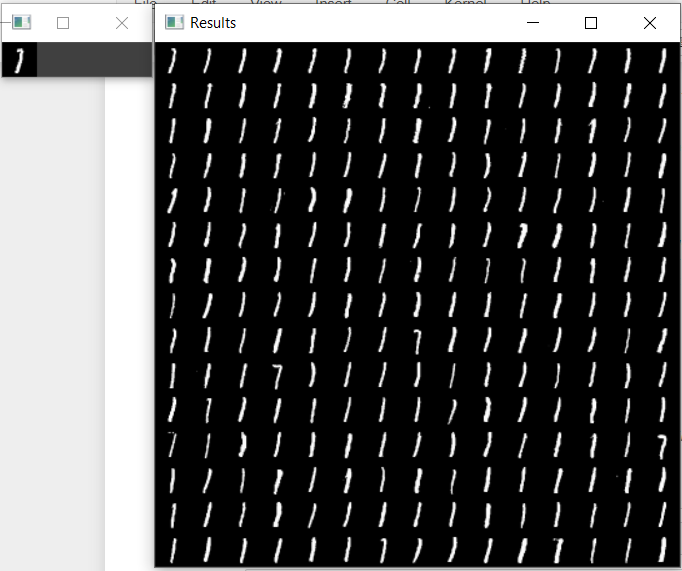